In [1]:
import sys
sys.path.insert(1, '../functions')
from gk import gk
from mwrko import mwrko
from gko import gko
from method import method
from method2 import method2
from compute_sin2 import compute_sin2
import math 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# importing necessary libraries
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from scipy import sparse
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from itertools import permutations

# Convergence Rate

#### GK

$$||x_k - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{m} \right) ^k ||x_0 - x^*||^2$$ or
$$||x_k - x^*||^2 \leq \Pi^{k-1}_{j = 0} \left ( 1 - \frac{\sigma^2_\min (A)}{4\gamma_j} \right) ||x_0 - x^*||^2$$ where $\gamma_j = \frac{||r_j||^2}{||r_j||^2_{\infty}}$. In this experiment, we are using first convergence rate for GK.

#### GKO and MWRKO

For k = 1: $$||x_1 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{m} \right) ||x_0 - x^*||^2$$

For k = 2: $$||x_2 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{ ( \max_i \sin^2\theta_i )(m-1)} \right)||x_1 - x^*||^2$$

For k > 2:

**GKO:** $$||x_{k+1} - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{\max_i \sin^2\theta_i} \right)||x_k - x^*||^2$$

**MWRKO:** $$||x_2 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{ ( \max_i \sin^2\theta_i )(m-2)} \right) ||x_k - x^*||^2$$

## Gaussian System

In [3]:
# setting up data
A = np.random.randn(5000,500)
A = normalize(A, axis=1, norm='l2')
m,n = A.shape
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [4]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
LH2_gko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_gko = 1- ( S2_min / max_angle_g )
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [6]:
# Run algorithms
gk_gaussian = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gaussian = method2(A,x,y,'GKO', LH1_gko, LH2_gko, LHk_gko, 0.5*10**-8)
mwrko_gaussian = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


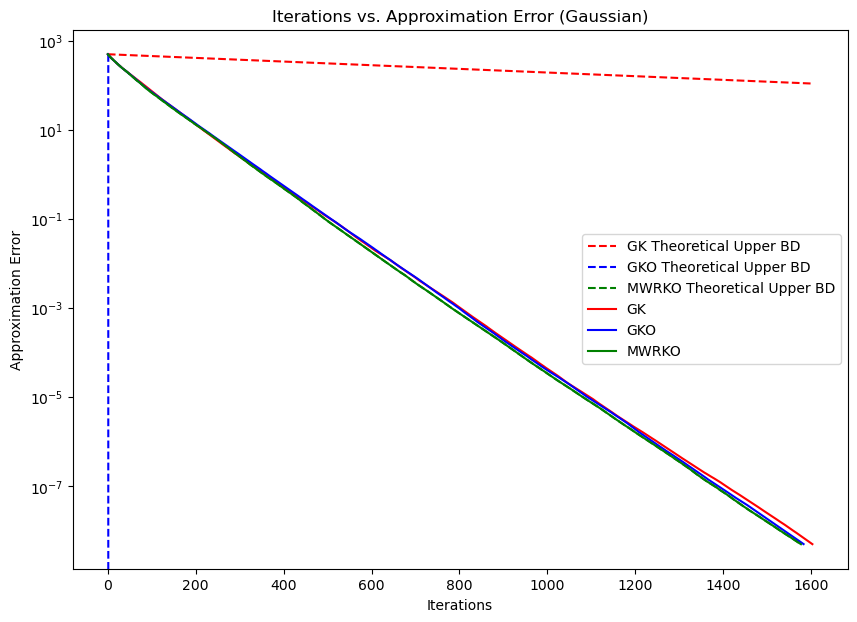

In [7]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gaussian[2])), gk_gaussian[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gaussian[2])), mwrko_gaussian[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gaussian[0]), gk_gaussian[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gaussian[0]), gko_gaussian[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gaussian[0]), mwrko_gaussian[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian)')
plt.legend()

## Uniform System

In [8]:
# setting up data
A = np.random.uniform(size =(5000,500), low = 0, high = 1)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [9]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [10]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
LH2_gko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_gko = 1- ( S2_min / max_angle_g )
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [11]:
# Run algorithms
gk_uniform = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_uniform = method2(A,x,y,'GKO', LH1_gko, LH2_gko, LHk_gko, 0.5*10**-8)
mwrko_uniform = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


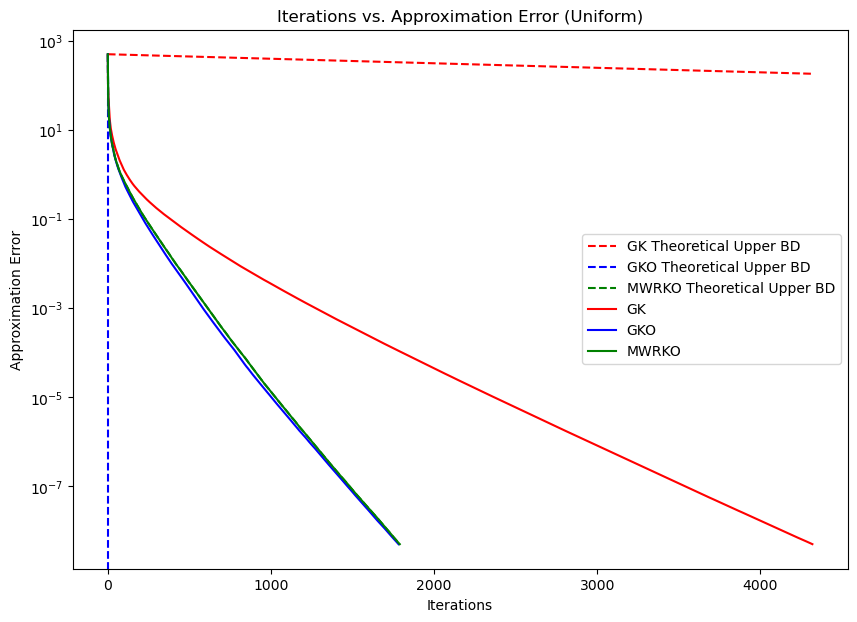

In [12]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_uniform[2])), gk_uniform[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_uniform[2])), mwrko_uniform[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_uniform[0]), gk_uniform[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_uniform[0]), gko_uniform[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_uniform[0]), mwrko_uniform[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform)')
plt.legend()

## 50/50 Gauss-Uniform System

In [13]:
# setting up data
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [14]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [15]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
LH2_gko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_gko = 1- ( S2_min / max_angle_g )
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [16]:
# Run algorithms
gk_gu1 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu1 = method2(A,x,y,'GKO', LH1_gko, LH2_gko, LHk_gko, 0.5*10**-8)
mwrko_gu1 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


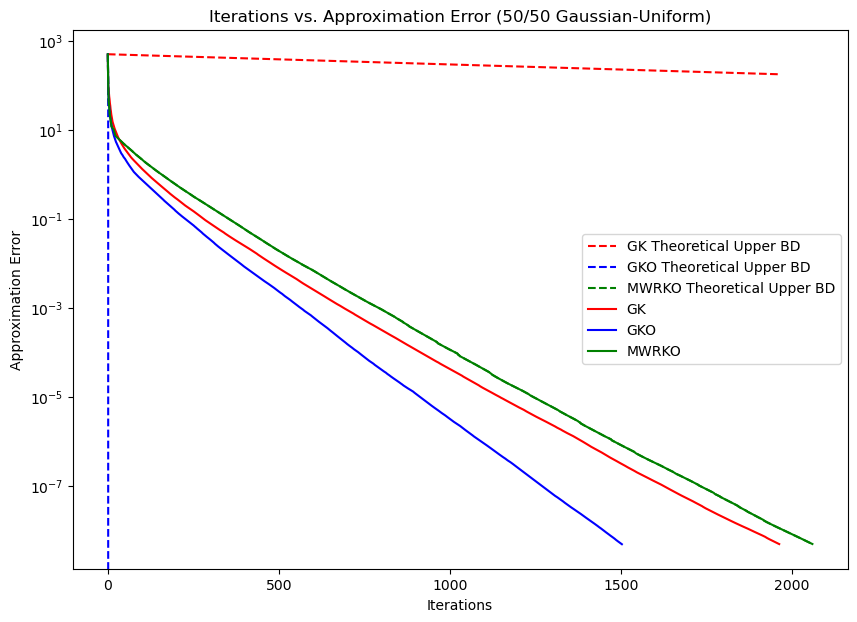

In [17]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu1[2])), gk_gu1[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu1[2])), mwrko_gu1[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu1[0]), gk_gu1[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu1[0]), gko_gu1[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu1[0]), mwrko_gu1[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gaussian-Uniform)')
plt.legend()

## 75/25 Gauss-Uniform System

In [18]:
# setting up data
A1 = np.random.rand(1250,500)
A2 = np.random.randn(3750,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [19]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [20]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
LH2_gko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_gko = 1- ( S2_min / max_angle_g )
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [21]:
# Run algorithms
gk_gu2 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu2 = method2(A,x,y,'GKO', LH1_gko, LH2_gko, LHk_gko, 0.5*10**-8)
mwrko_gu2 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


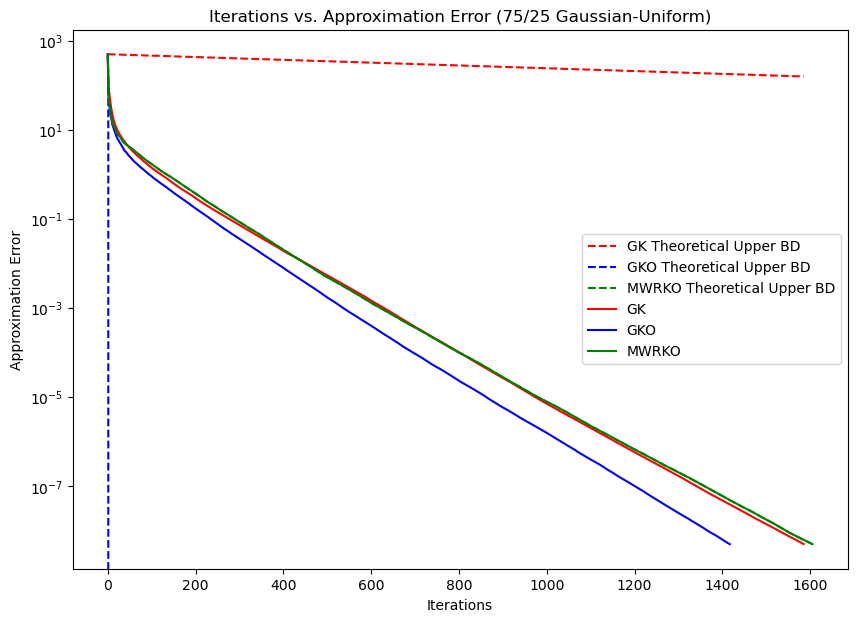

In [22]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu2[2])), gk_gu2[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu2[2])), mwrko_gu2[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu2[0]), gk_gu2[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu2[0]), gko_gu2[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu2[0]), mwrko_gu2[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gaussian-Uniform)')
plt.legend()

## 25/75 Gauss-Uniform System

In [23]:
# setting up data
A1 = np.random.rand(3750,500)
A2 = np.random.randn(1250,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [24]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [25]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
LH2_gko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_gko = 1- ( S2_min / max_angle_g )
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [26]:
# Run algorithms
gk_gu3 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu3 = method2(A,x,y,'GKO', LH1_gko, LH2_gko, LHk_gko, 0.5*10**-8)
mwrko_gu3 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


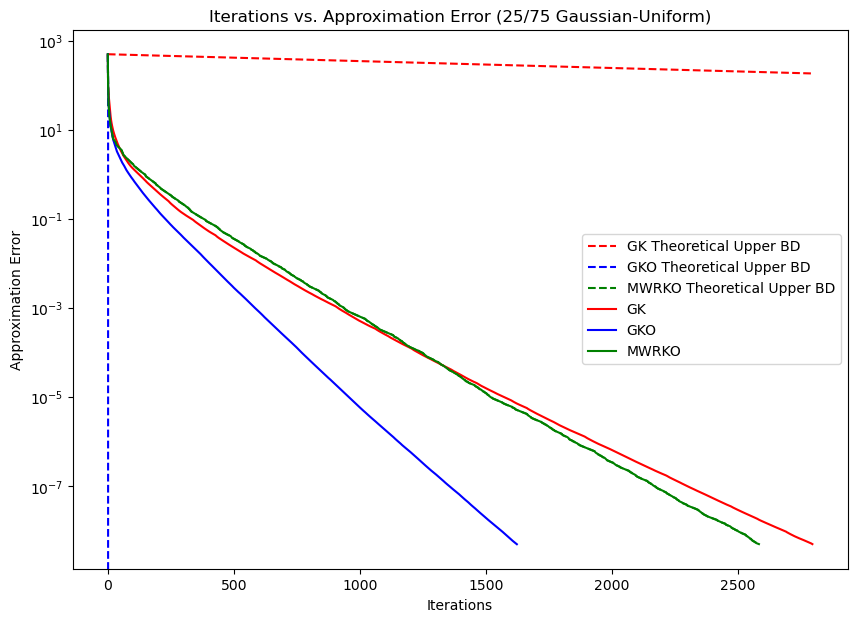

In [27]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu3[2])), gk_gu3[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu3[2])), mwrko_gu3[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu3[0]), gk_gu3[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu3[0]), gko_gu3[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu3[0]), mwrko_gu3[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gaussian-Uniform)')
plt.legend()

## Two Highly Correlated Systems

In [28]:
# setting up data
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))
# Step 2: generate correalted systems
U = np.random.uniform(low = 0, high = 1, size  = (2500,500))
A1 =  np.tile(A1, (2500, 1)) +  U
A2 =  np.tile(A2, (2500, 1)) +  U
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [29]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [30]:
# Run algorithms
gk_corr = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_corr = method2(A,x,y,'GKO', LH1_gko, LH2_gko, LHk_gko, 0.5*10**-8)
mwrko_corr = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


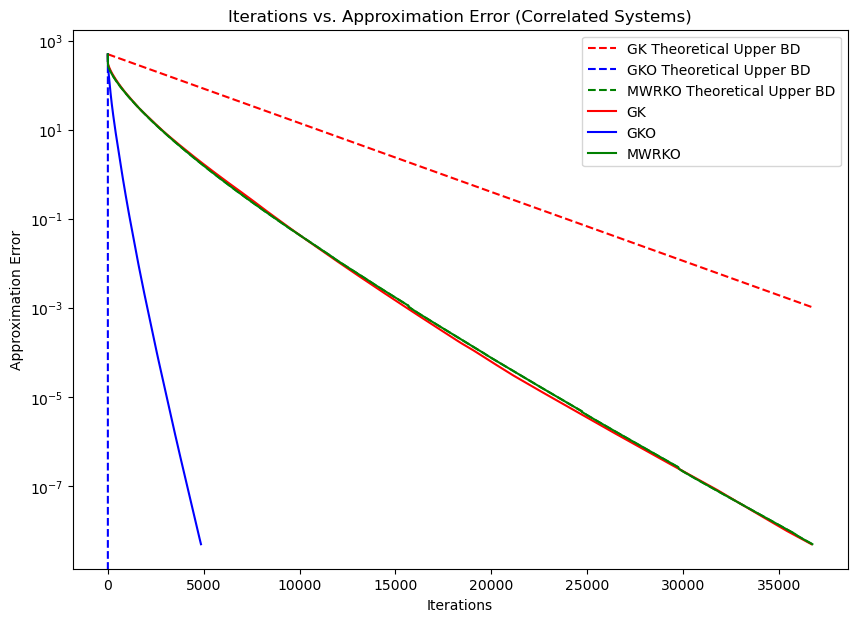

In [31]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_corr[2])), gk_corr[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_corr[2])), gko_corr[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_corr[2])), mwrko_corr[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_corr[0]), gk_corr[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_corr[0]), gko_corr[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_corr[0]), mwrko_corr[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems)')
plt.legend()